In [1]:
import pandas as pd
import time
import seaborn as sns
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from wordcloud import WordCloud
import string
import numpy as np


In [2]:
# for LDA model
from sklearn.decomposition import LatentDirichletAllocation

# for CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# for Porter Stemmer
from nltk.stem import PorterStemmer

# for Stop Words
from nltk.corpus import stopwords

# for Tokenizer
from nltk.tokenize import word_tokenize

import networkx as nx

# 1. Load Data

In [3]:
df = pd.read_csv('cleaned_reviews.csv')

# 2. preprocess data

In [4]:
data = df['clean_reviews'].tolist()

In [5]:
def preprocess_data(text):
    # Tokenize the text
    tokens = text.split()
    
    # Remove stop words
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stem the words
    #stemmer = PorterStemmer()
    #tokens = [stemmer.stem(token) for token in tokens]
    
    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]
    
    return " ".join(tokens)

In [6]:
processed_data = [preprocess_data(review) for review in data]

# LDA Model

In [7]:
# Fit the CountVectorizer object to the cleaned text data
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(processed_data)

# Fit the LDA model to the vectorized text data
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(X)

# Print the top 10 words for each topic
feature_names = list(vectorizer.vocabulary_.keys())
sorted_feature_names = [feature_names[i] for i in sorted(vectorizer.vocabulary_.values())]
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [sorted_feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: ring, undermining, otherswhat, launched, escapeit, que, hawks, 1879, cliff, righteousness
Topic 1: undermining, ring, otherswhat, launched, escapeit, cliff, que, frowned, mexico, 1879
Topic 2: undermining, otherswhat, ring, righteousness, escapeit, cliff, launched, topmost, que, 1879
Topic 3: undermining, ring, otherswhat, que, boooo, launched, hawks, mexico, topmost, squarely
Topic 4: ring, undermining, otherswhat, que, hawks, cliff, hike, launched, carpthe, squarely
Topic 5: undermining, otherswhat, ring, vengeance, hike, que, righteousness, rising, royalslook, cliff
Topic 6: undermining, foldi, kohinoor, blogshow, vengeance, prohibited, actuallyanyway, ring, topmost, unread
Topic 7: undermining, cliff, ring, tumultuous, righteousness, squarely, carpthe, incredulous, boooo, escapeit
Topic 8: undermining, ring, otherswhat, que, cliff, launched, frowned, hawks, boooo, 1879
Topic 9: undermining, ring, topmost, otherswhat, escapeit, hawks, frowned, launched, que, 1879


### Its really hard to make out what the topic is for each of them but undermining seems to pop up in all of these words 

In [8]:
# Get the topic-term probabilities
topic_term_probs = lda_model.components_

# Print the shape of the topic-term matrix
print(f"Topic-term matrix shape: {topic_term_probs.shape}")
print(lda_model.components_)

Topic-term matrix shape: (10, 15234)
[[0.10000225 0.1        0.1        ... 0.1        0.1        0.1       ]
 [0.1        1.1        0.10002353 ... 0.1        0.1        1.1       ]
 [1.45483254 0.1        0.1        ... 0.1        0.1        0.1       ]
 ...
 [0.1        0.1        0.1        ... 0.1        0.1        0.1       ]
 [0.10001618 0.1        0.1        ... 0.1        0.1        0.1       ]
 [0.10000152 0.1        0.1        ... 0.1        0.1        0.1       ]]


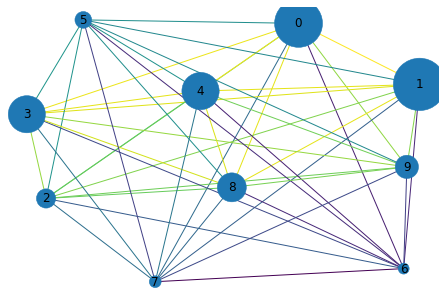

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

topic_docs = {}
for doc_idx, topic_idx in enumerate(lda_model.transform(X)):
    if topic_idx.argmax() not in topic_docs:
        topic_docs[topic_idx.argmax()] = [doc_idx]
    else:
        topic_docs[topic_idx.argmax()].append(doc_idx)

# Calculate pairwise cosine similarity between topics
similarity_matrix = cosine_similarity(lda_model.components_)

# Create network graph
G = nx.Graph()

# Add nodes to graph (one for each topic)
for i in range(lda_model.n_components):
    G.add_node(i)

# Add edges to graph
for i in range(lda_model.n_components):
    for j in range(i + 1, lda_model.n_components):
        similarity = similarity_matrix[i, j]
        if similarity > 0:
            G.add_edge(i, j, weight=similarity)
            
# Set node sizes based on the number of documents assigned to each topic
node_sizes = [len(topic_docs[topic]) * 10 for topic in range(lda_model.n_components)]

# Set edge colors based on edge weights
edge_colors = [edge[2]['weight'] for edge in G.edges(data=True)]

# Draw network graph using spring layout
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=node_sizes, edge_color=edge_colors, cmap=plt.cm.Blues, with_labels=True)

# Show the plot
plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [11]:


# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the text data to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data)

# Create NMF model with 10 topics
nmf_model = NMF(n_components=10, random_state=42)

# Fit the NMF model to the TF-IDF matrix
nmf_model.fit(tfidf_matrix)

# Print the top 10 words for each topic
feature_names = list(tfidf_vectorizer.vocabulary_.keys())
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")

Topic 0: undermining, cliff, righteousness, vengeance, ratty, royalslook, que, hike, tumultuous, childrens
Topic 1: mexico, que, fleece, dirt, himalas, negativity, naughty, engagements, rorkes, americas
Topic 2: topmost, undermining, whollyi, ring, escapeit, unity, blogshow, 1879, incredulous, 28m
Topic 3: ring, hawks, incredulous, unpalatable, hike, boooo, celebrate, squarely, justificando, life2
Topic 4: otherswhat, escapeit, returning, launched, cali, foundations, commands, ring, trappings, seder
Topic 5: actuallyanyway, hesitant, lyrically, distracting, acceptance, hawks, implicit, respond, dictionary, unspoken
Topic 6: behavioural, himalas, woowee, curiousand, 11x, boooo, lol, grant, pan, 1879
Topic 7: frowned, launched, sentia, descendant, rawly, 1879, colored, result, rorkes, coaccionada
Topic 8: wallowed, strugglesjust, foundationsinitiatives, crosssection, inspiringshow, excruciating, carlos, blinkers, conflict, complete
Topic 9: carpthe, generalize, mostall, wellbalanced, rev

C:\Users\ruskin.dantra\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


### This model seems to do a better job of helping us identify the topics - words like mexico help us figure it out

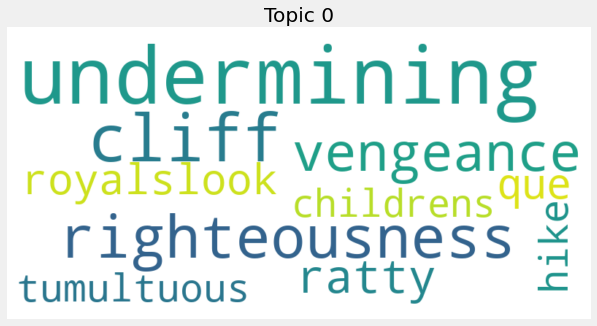

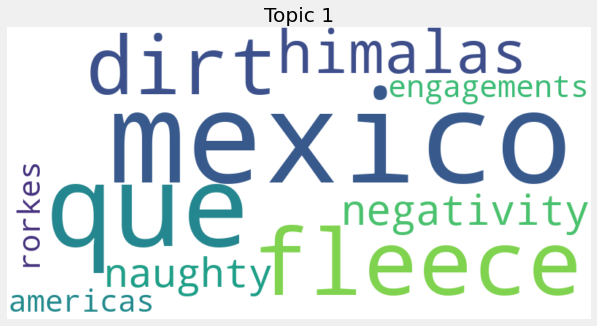

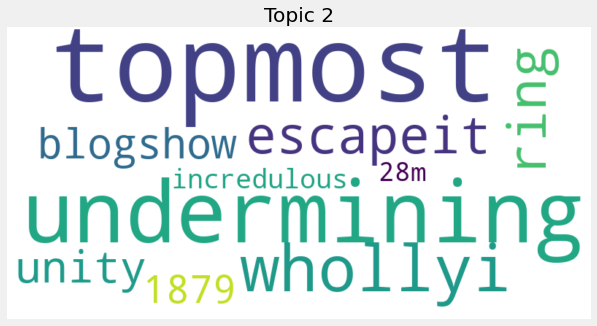

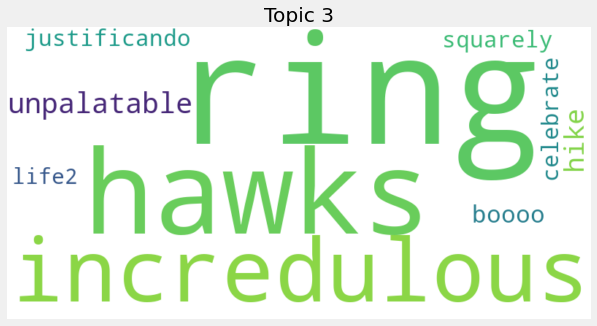

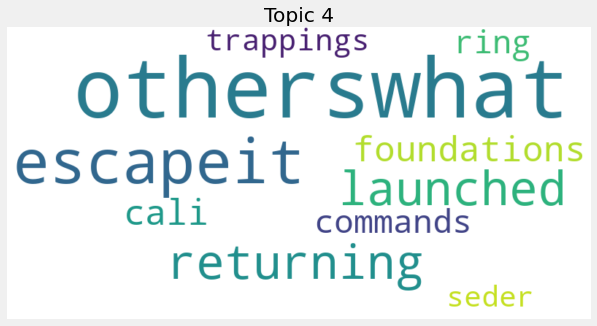

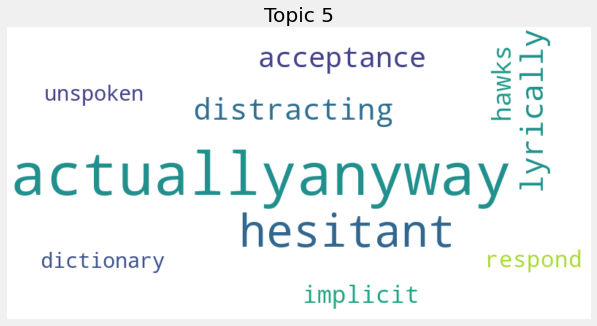

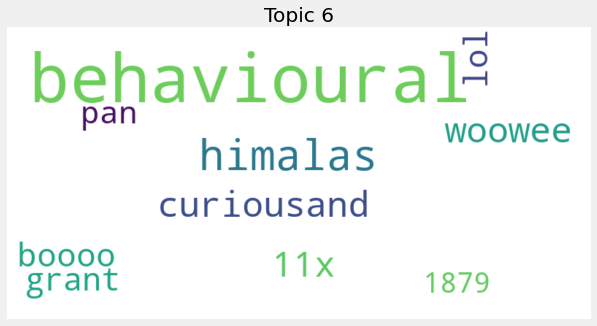

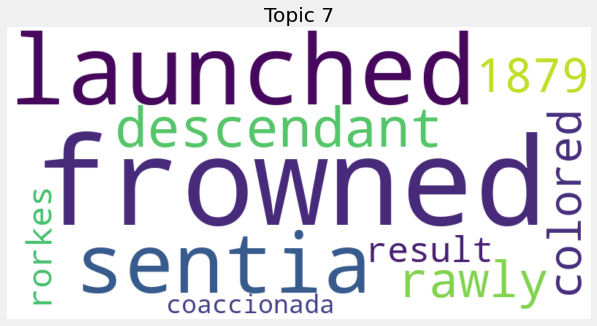

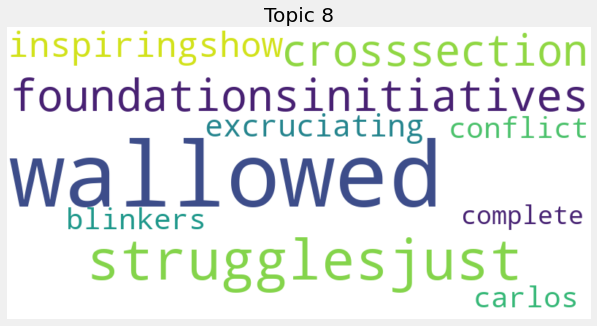

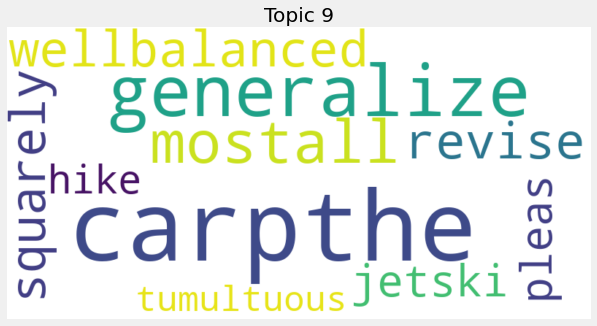

In [55]:
# Create a word cloud for each topic
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-11:-1]}
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(top_words)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx}")
    plt.show()

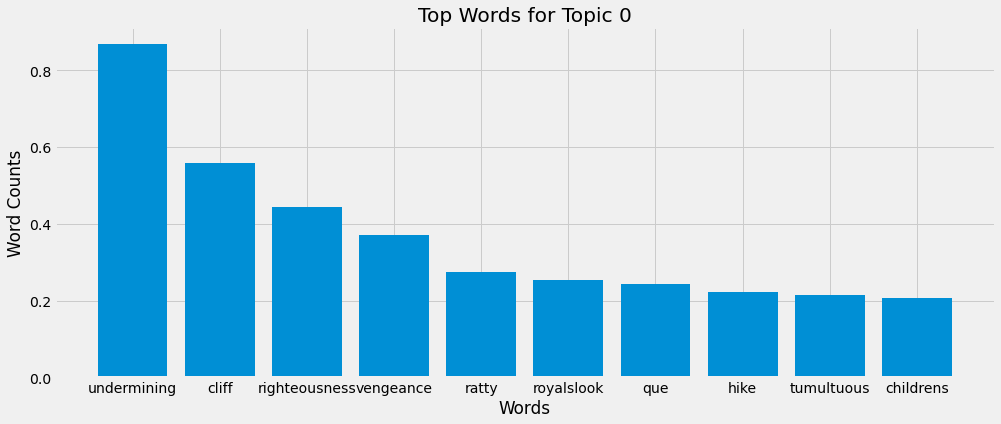

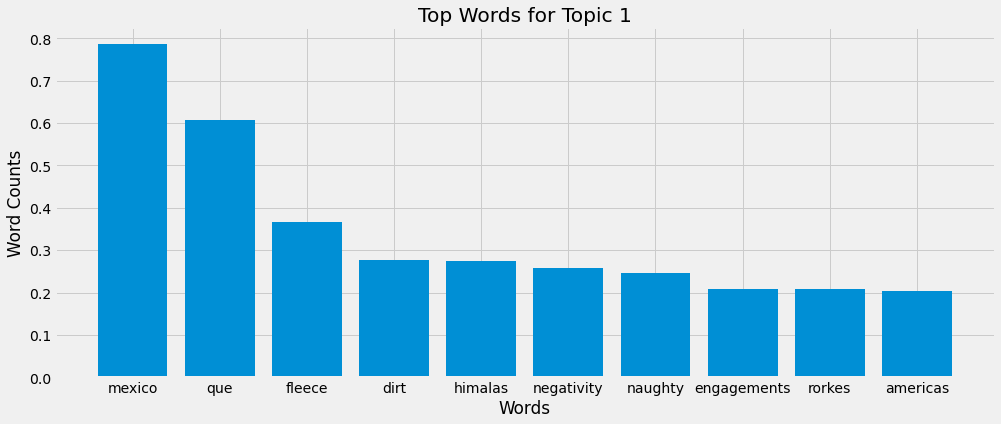

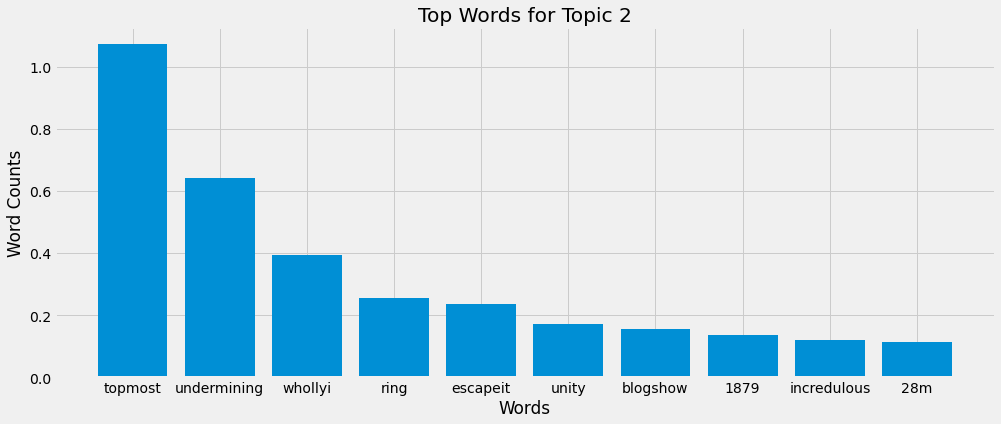

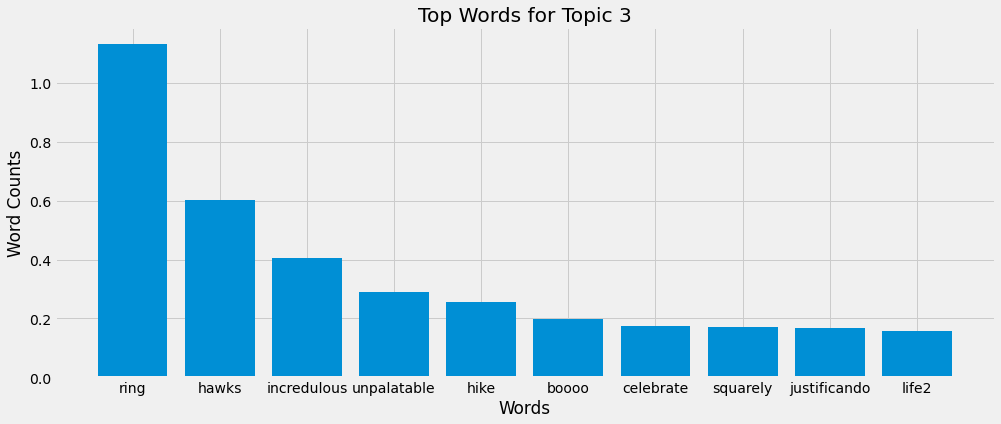

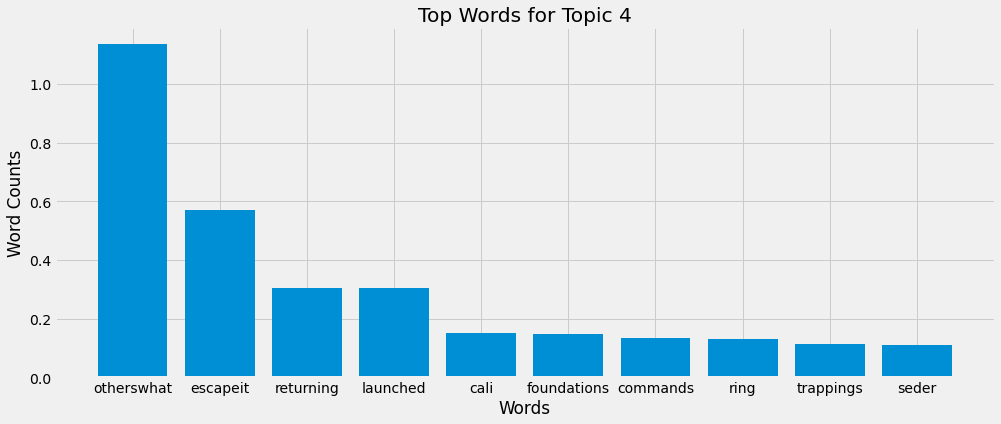

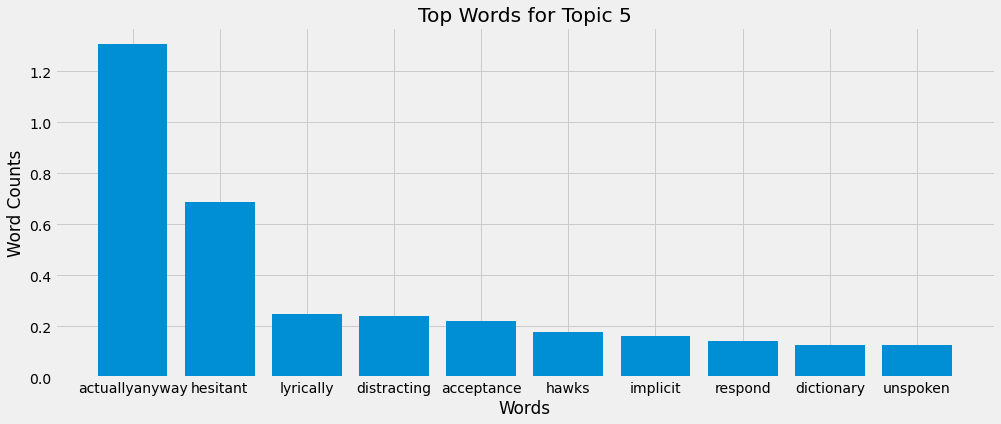

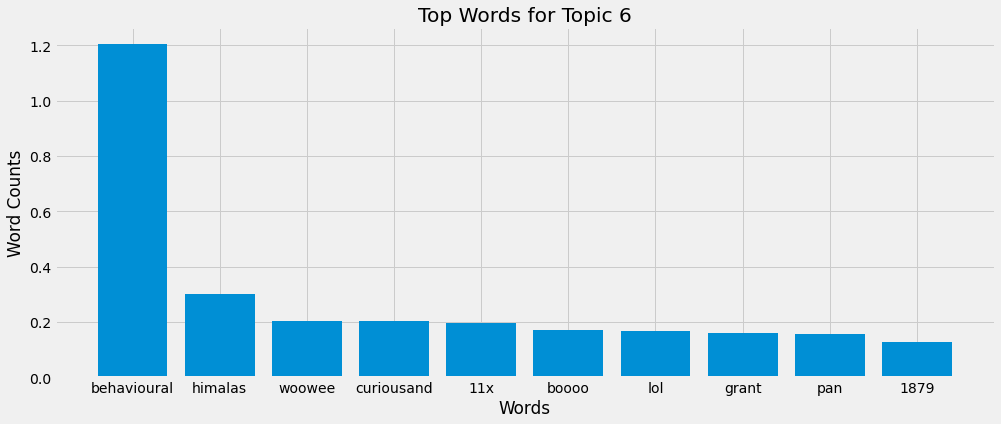

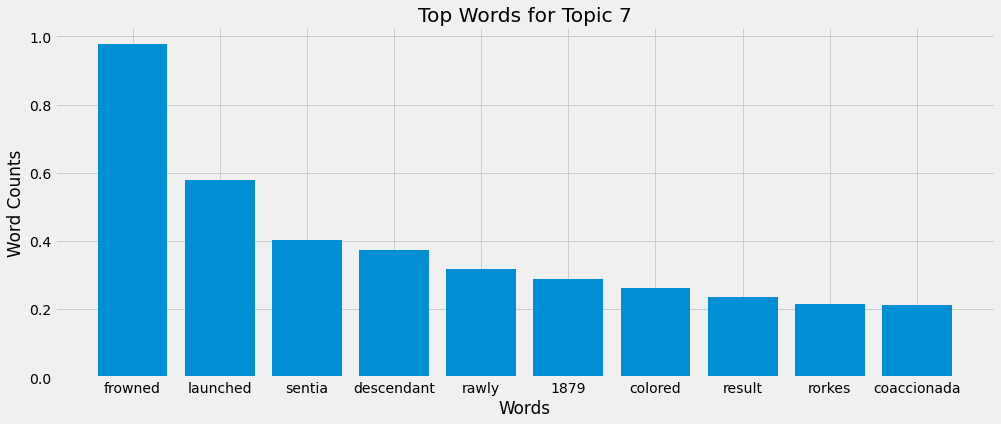

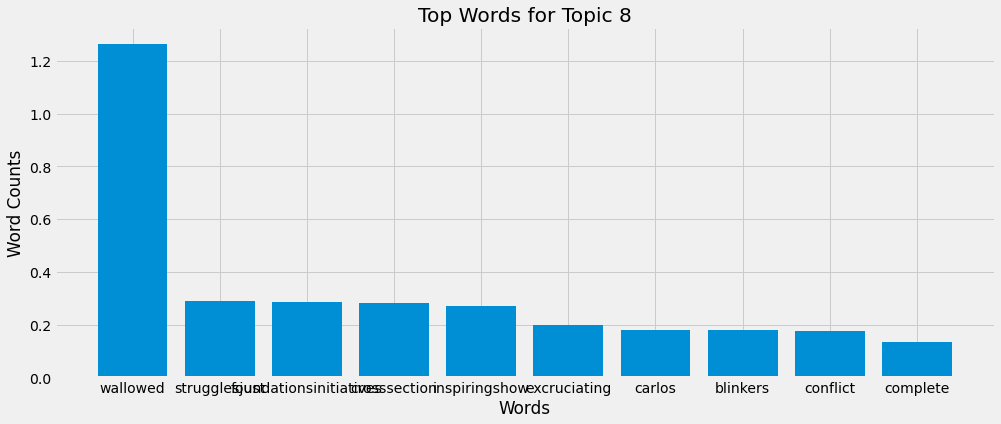

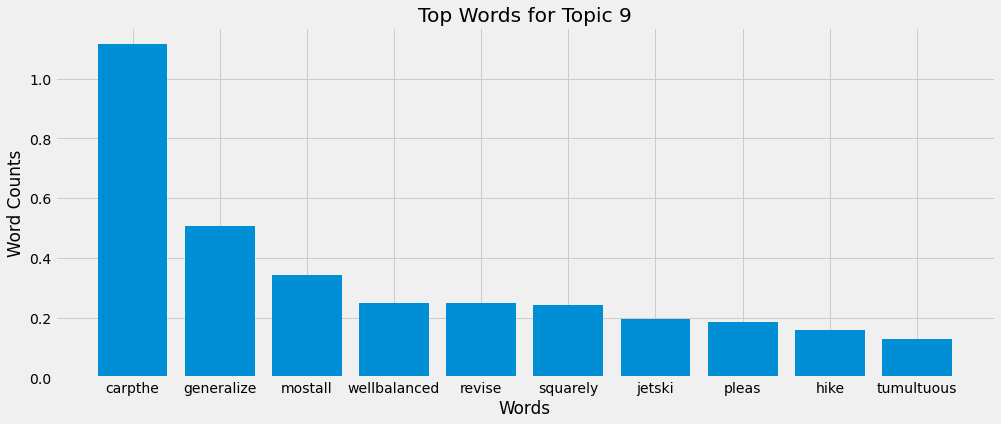

In [21]:
# Get the feature names (words)
feature_names = list(tfidf_vectorizer.vocabulary_.keys())

# Create a bar chart for each topic
for topic_idx, topic in enumerate(nmf_model.components_):
    
    top_words_idx = topic.argsort()[::-1][:10]
    top_word_counts = topic[top_words_idx]
    top_words = [feature_names[i] for i in top_words_idx]
    plt.figure(figsize=(15, 6))
    plt.bar(top_words, top_word_counts)
    plt.title(f"Top Words for Topic {topic_idx}")
    plt.xlabel("Words")
    plt.ylabel("Word Counts")
    plt.show()


In [23]:
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data)

In [24]:
tfidf_matrix

<1011x15234 sparse matrix of type '<class 'numpy.float64'>'
	with 92192 stored elements in Compressed Sparse Row format>

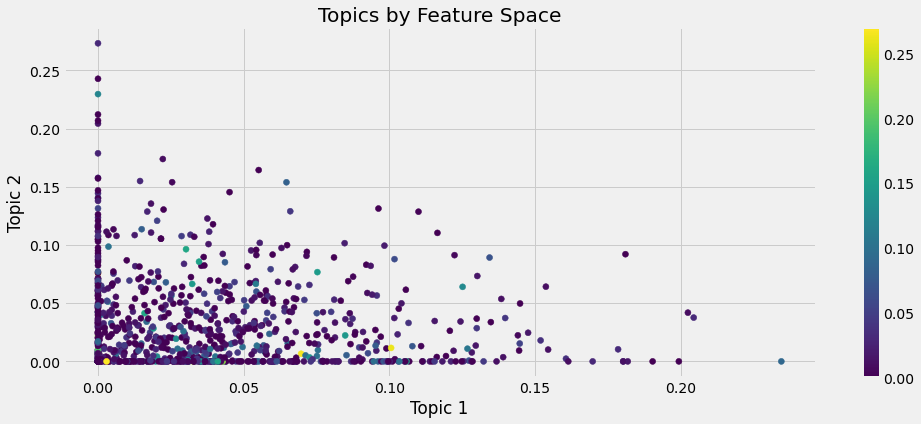

In [28]:
# Create a scatter plot for the topics
topics = nmf_model.transform(tfidf_matrix)
plt.figure(figsize=(15, 6))
plt.scatter(topics[:, 0], topics[:, 1], c=topics[:, 2], cmap='viridis')
plt.title("Topics by Feature Space")
plt.xlabel("Topic 1")
plt.ylabel("Topic 2")
plt.colorbar()
plt.show()

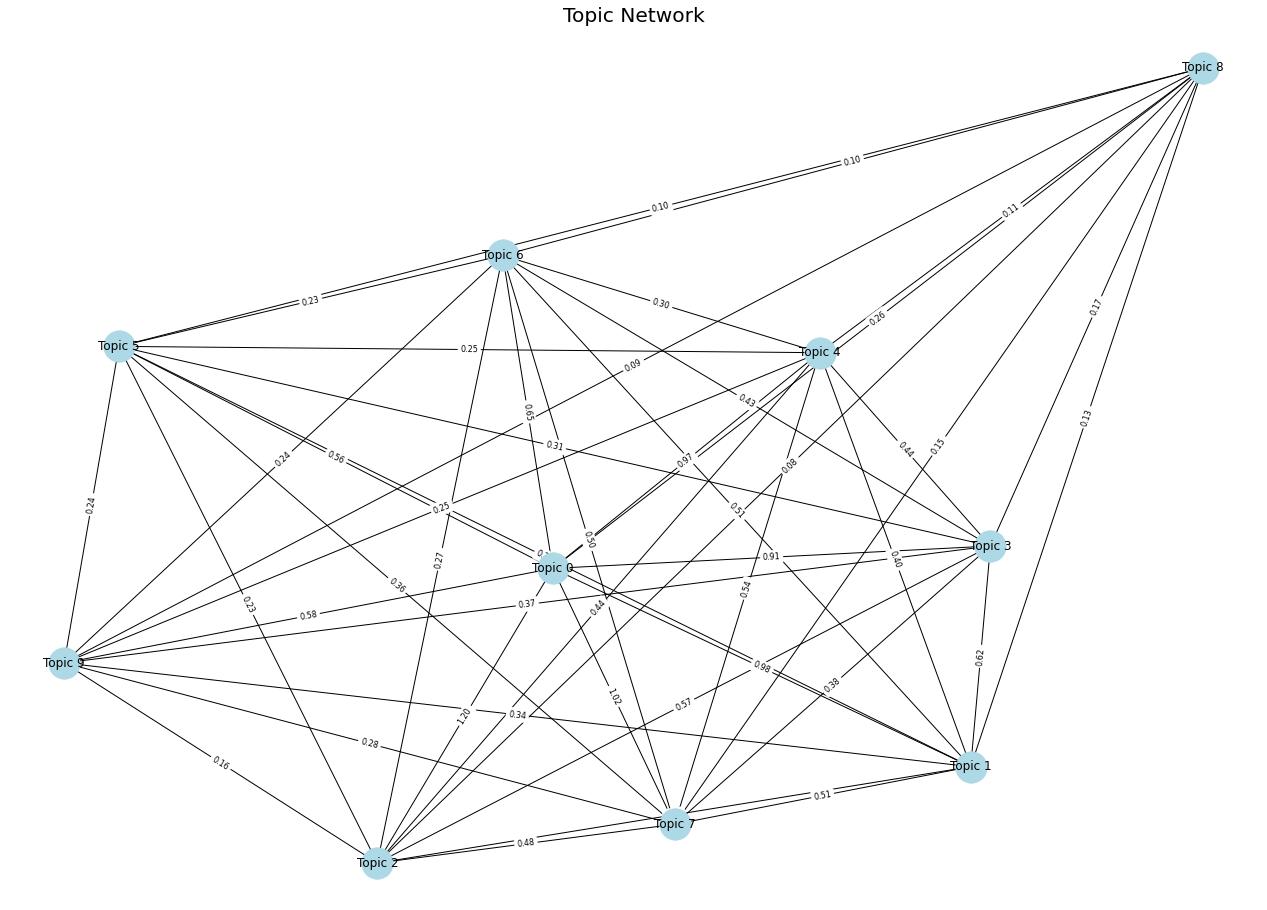

In [31]:
# Create a topic network
G = nx.Graph()
for i, topic_i in enumerate(nmf_model.components_):
    for j, topic_j in enumerate(nmf_model.components_):
        if i != j:
            weight = np.sum(topic_i * topic_j)
            G.add_edge(f"Topic {i}", f"Topic {j}", weight=weight)

# Draw the topic network
fig, ax = plt.subplots(figsize=(20, 15))  # Set the figure size

pos = nx.spring_layout(G)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=12)
plt.title("Topic Network")
plt.show()

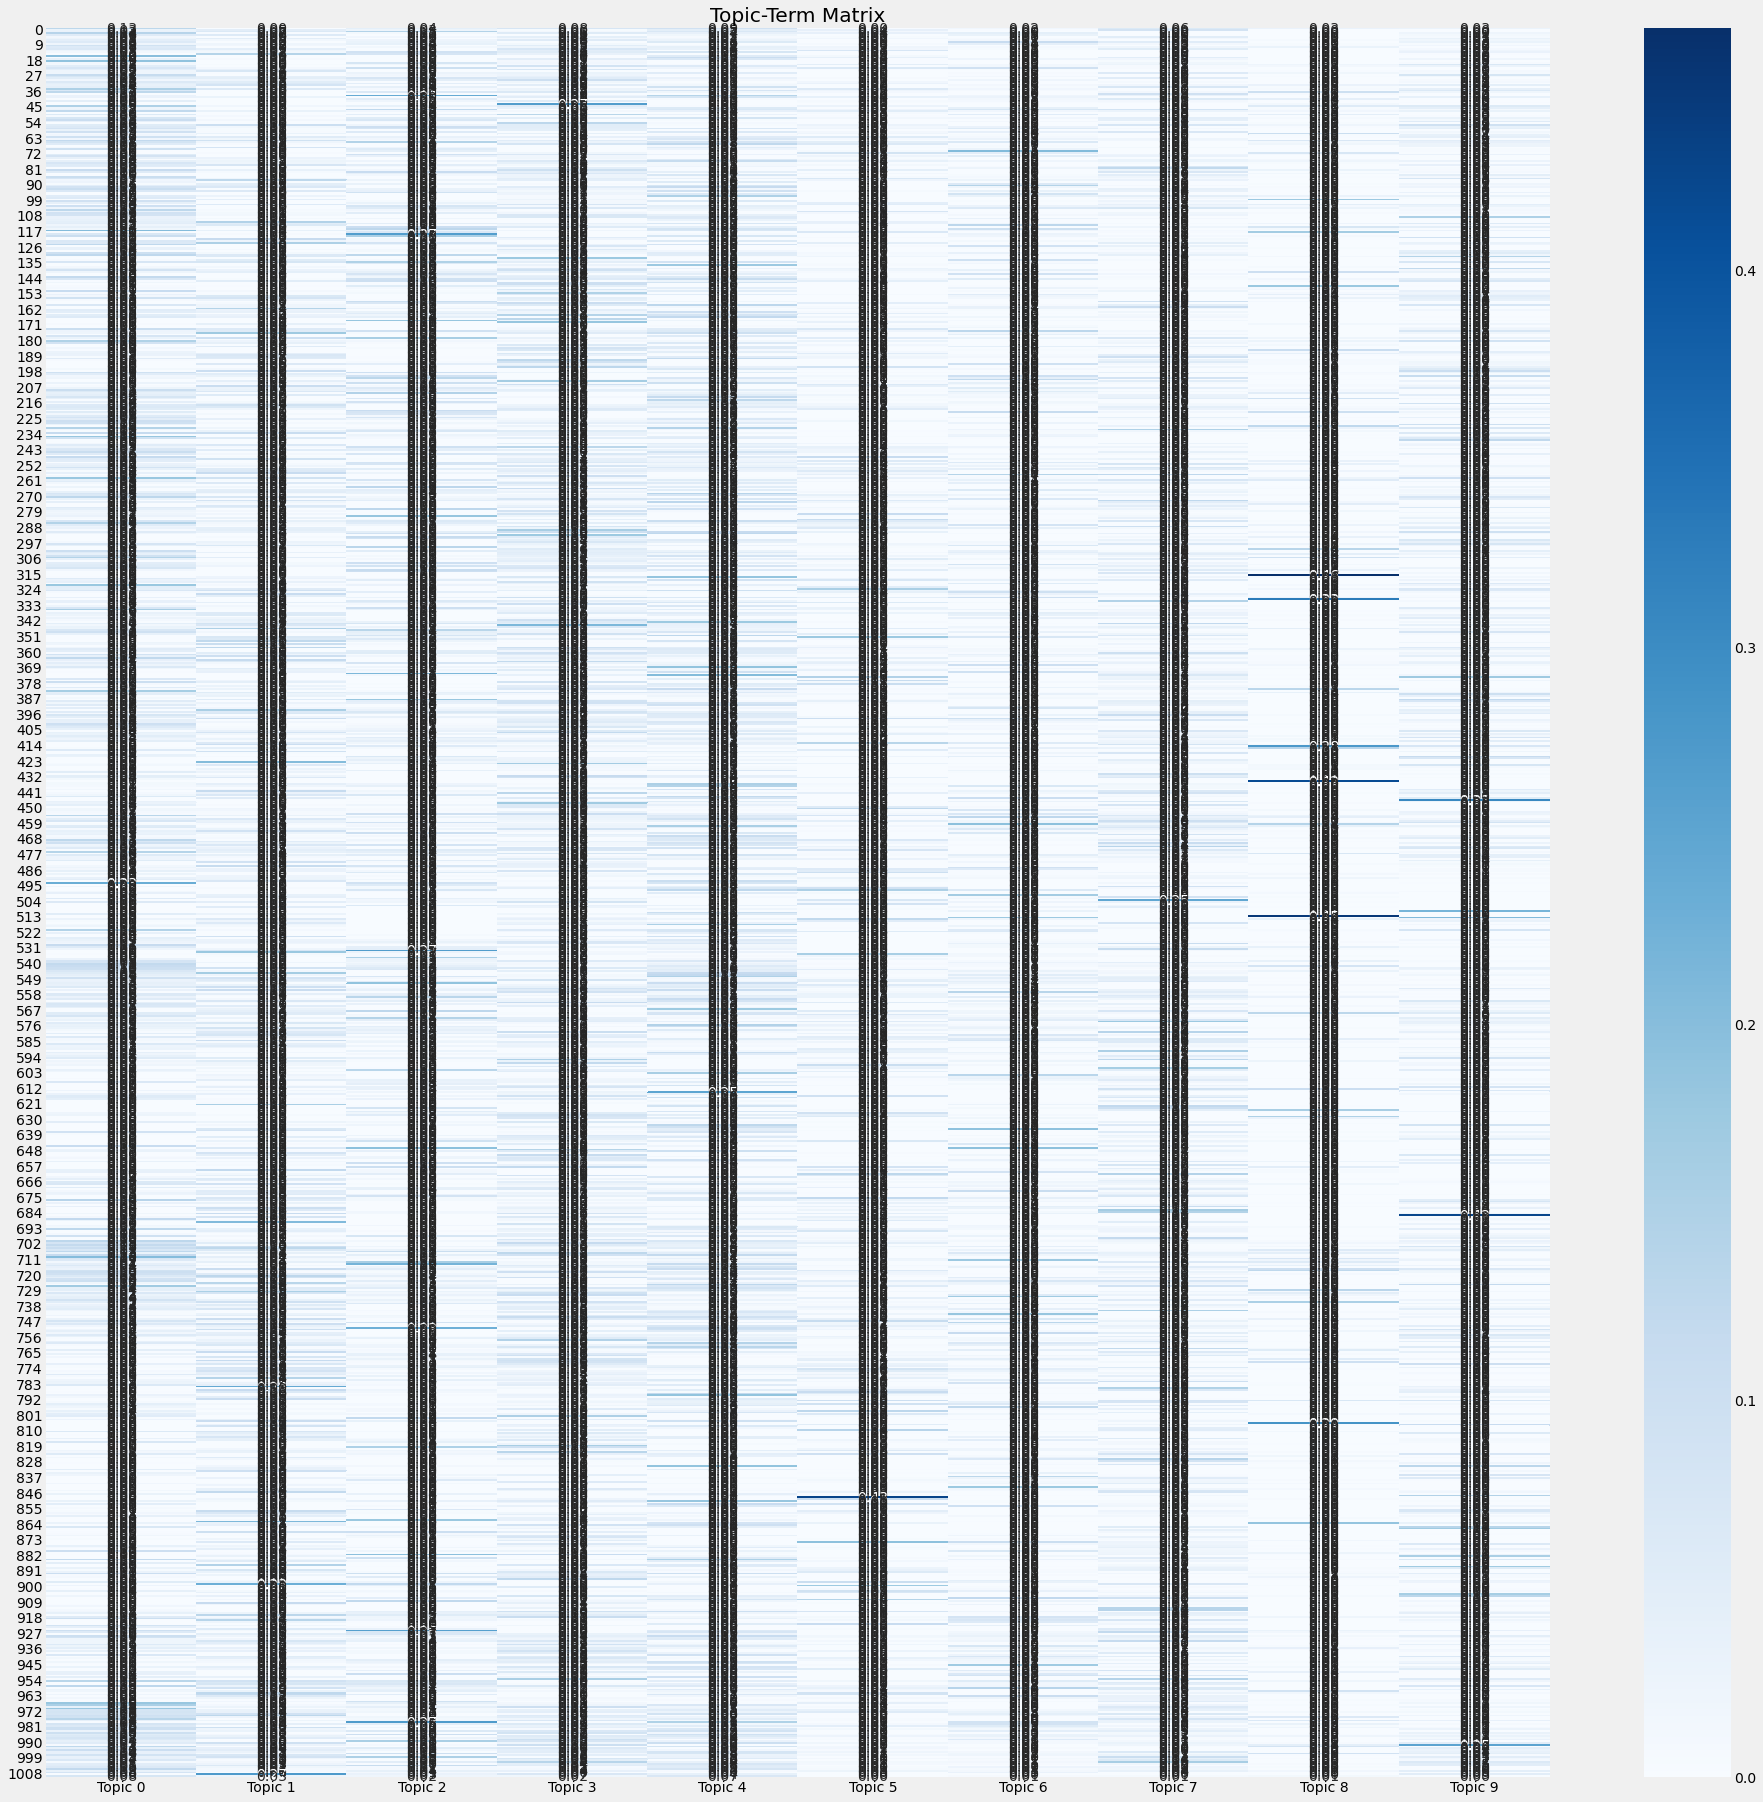

In [19]:
# Create a topic-term matrix
topic_term_matrix = nmf_model.transform(tfidf_vectorizer.transform(processed_data))
df_topic_term = pd.DataFrame(topic_term_matrix, columns=[f"Topic {i}" for i in range(10)])

# Create a heatmap of the topic-term matrix
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(df_topic_term, cmap="Blues", annot=True, fmt=".2f", ax=ax)
ax.set_title("Topic-Term Matrix")
plt.show()